In [1]:
import os
import sys
import shutil
from pathlib import Path

os.chdir('../')
sys.path.append('../training_pipeline')

In [2]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import numpy as np
import torch
import yaml
import torch.nn.functional as F
from tqdm.notebook import tqdm as tqdm_n
from tqdm import tqdm
from torchsummary import summary

sns.set()
%matplotlib inline

In [3]:
from config_structure import TrainConfigParams
from tasks import create_task
from models import create_backbone
from registry import TASKS, METRICS
from tasks.tumor_segmentation_task import ExponentialMovingAverage

In [4]:
def plot_images(imgs, names=None, axs=None, show=True, nrows=None, ncols=None, figsize=(16, 8)):
    if not isinstance(imgs, list):
        imgs = [imgs]
    
    from math import ceil
    if nrows is None and ncols is None:
        nrows = 1
        ncols = len(imgs)
    elif nrows is None:
        nrows = ceil(len(imgs) / ncols)
    elif ncols is None:
        ncols = ceil(len(imgs) / nrows)
    
    if axs is None:
        fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    if nrows == 1 and ncols == 1:
        axs.imshow(imgs[0])
        axs.set_axis_off()
        if names and len(names) > 0:
            axs.set_title(names[0], fontsize=15)
    elif nrows == 1 or ncols == 1:
        for j, ax in enumerate(axs):
            ax.imshow(imgs[j])
            ax.set_axis_off()
            if names and j < len(names):
                ax.set_title(names[j], fontsize=15)
    else:
        for j, ax in enumerate(axs):
            for k, sub_ax in enumerate(ax):
                image_id = j * ncols + k
                sub_ax.set_axis_off()
                if image_id < len(imgs):
                    sub_ax.imshow(imgs[image_id])
                    if names and image_id < len(names):
                        sub_ax.set_title(names[image_id], fontsize=15)
    if show:
        plt.show()
        
        
def cut_borders_and_resize(image: np.ndarray, original_size) -> np.ndarray:
    desired_size = image.shape[0]
    ratio = float(desired_size)/max(original_size)
    w, h = tuple([int(x*ratio) for x in original_size])

    if h > w:
        cut = (h - w) // 2
        image = image[:, cut:-cut]
    elif w > h:
        cut = (w - h) // 2
        image = image[cut:-cut]
#     print(image.shape, original_size)

    return cv2.resize(image, original_size)

def dilation_erosion(probs, i=1, kernel=None, er_iter_num=2, dil_item_num=1):
    if kernel is None:
        kernel = np.ones((3, 3), np.uint8)
    new_probs = probs.copy()
    mask = new_probs[i] if new_probs.ndim == 3 else new_probs
    for j in range(er_iter_num):
        mask = cv2.dilate(mask, kernel, iterations=1)
        mask = mask ** 2
        
    if new_probs.ndim == 3:
        new_probs[i] = cv2.dilate(mask, kernel, iterations=dil_item_num)
        new_probs /= new_probs.sum(axis=0)
    else:
        new_probs = mask
    return new_probs
    
def prepare_task(config_path, checkpoint_path, device=torch.device('cuda'), custom_forward=None):
    config_yaml = yaml.load(open(config_path, "r"), Loader=yaml.FullLoader)
    config = TrainConfigParams(**config_yaml)
    model_class = TASKS.get(config.task.name)
    
    if custom_forward is not None:
        if callable(custom_forward):
            model_class.forward = custom_forward
        else:
            raise TypeError('`custom_forward` is not callable')
    
    model = model_class(config).to(device)
    model.freeze()
    state_dict = torch.load(checkpoint_path, map_location=device)['state_dict']
    model.load_state_dict(state_dict, strict=False)
    model.prepare_data()
    return model

In [5]:
from copy import deepcopy

In [280]:
device = torch.device('cuda')
# path_to_config = Path('configs/tumor_segmentation_16_32(16)_256.yml')
# path_to_config = Path('configs/tumor_segmentation_ema_gn_8_32(16)_256.yml')
path_to_config = Path('configs/tumor_segmentation_16_32_512.yml')

# path_to_config = Path('configs/tumor_segmentation_ema_16_32_256.yml')
# path_to_config = Path('configs/tumor_segmentation_ema_gn_8_32(16)_256.yml')


path_to_checkpoint = Path('logs/unet_effnetb0_in_float16_s512/2020-09-13_16-08-40/last.ckpt')
# path_to_checkpoint = Path('logs/unet_effnetb0_in_float16_s256/2020-09-13_09-04-24/last.ckpt') # 0.6819675048169751
# path_to_checkpoint = Path('logs/unet_effnetb0_in_float32_s256_attn_ema/2020-09-13_12-25-31/last.ckpt') # 0.7537883440457961

# path_to_checkpoint = Path('logs/unet_effnetb0_gn_float16_s256/2020-09-12_13-37-58/last.ckpt')
# path_to_checkpoint = Path('logs/unet_effnetb0_gn_float16_s256_attn_ema/2020-09-12_20-23-49/last.ckpt')

In [281]:
model = prepare_task(path_to_config, path_to_checkpoint, device)

Pretrained weights for efficientnet_b0 will be downloaded


In [277]:
model = prepare_task(path_to_config, path_to_checkpoint, device)
# model = model.half()

model_ema = prepare_task(path_to_config, path_to_checkpoint, device)
# model_ema = model.half()
ema_parameters = list(torch.load(path_to_checkpoint, map_location=device)['optimizer_states'][0]['ema_parameters'])
# for i, param in enumerate(ema_parameters):
#     ema_parameters[i] = param.half()

new_state_dict = {}
for s_param, (name, param) in zip(ema_parameters, model_ema.named_parameters()):
    new_state_dict[name] = s_param
model_ema.load_state_dict(new_state_dict, strict=False)

print((list(model_ema.parameters())[0] - list(model.parameters())[0]).sum())
print((list(model_ema.parameters())[0] - list(ema_parameters)[0]).sum())
print((list(ema_parameters)[0] - list(model.parameters())[0]).sum())

Pretrained weights for efficientnet_b0 will be downloaded
Pretrained weights for efficientnet_b0 will be downloaded
tensor(-0.0013, device='cuda:0')
tensor(0., device='cuda:0')
tensor(-0.0013, device='cuda:0')


In [223]:
rand_sample = torch.rand(1, 1, 256, 256, device=device, dtype=model.dtype)

In [224]:
traced_model = torch.jit.trace(model, rand_sample, check_tolerance=1e-3)
# torch.jit.save(traced_model, "logs/tumor_segmentator_v4.pt")

In [225]:
batch_sizes = [1, 2]
input_size = rand_sample.shape[1:]
for batch_size in batch_sizes:
    print(f"Batch size: {batch_size}")
    input_tensor = torch.rand(batch_size, *input_size, device=device, dtype=model.dtype)
    %timeit model(input_tensor)
    %timeit traced_model(input_tensor)
    print()

Batch size: 1
12 ms ± 293 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.87 ms ± 5.83 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Batch size: 2
12.1 ms ± 263 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.4 ms ± 151 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)



In [285]:
ious = []
f1s = []

pred_masks = []
labels = []
pred_probs = []

loader = model.val_dataloader()
dataset = loader.dataset

iou_meter = METRICS.get('IntersectionOverUnionMeter')(target_class=1, average='samples', 
                                                      reduce=False, binary_mod=True)
f1_meter = METRICS.get('F1Meter')(get_logits=True, num_classes=3)
for i, batch in tqdm(enumerate(loader), total=len(loader)):
    batch['input'] = batch['input'].to(device)

    mask_pred, label_pred = model(batch['input'])
#     mask_pred, label_pred = model_ema(batch['input'])
    label_pred = torch.softmax(label_pred, dim=1).cpu().numpy()
    labels.append(label_pred)
        
    mask_pred = mask_pred.cpu().numpy()
    ious += iou_meter.calculate(target=batch['target_mask'].numpy(),
                                prediction=mask_pred)
    f1_meter.update(target=batch['target_label'].numpy(),
                    prediction=label_pred)
    pred_masks.append(mask_pred)
    
torch.cuda.empty_cache()
pred_masks = np.concatenate(pred_masks)
labels = np.concatenate(labels).astype('float')
        
ious = torch.tensor(ious)
idxs = torch.argsort(ious)

    
pred_probs = 1 / (1 + np.exp(-pred_masks)).astype('float')
pred_masks = pred_masks.astype('float')


100%|██████████| 29/29 [00:06<00:00,  4.24it/s]


In [286]:
ious.mean().item()

0.7631752114089331

In [287]:
# no EMA, int16, float32, 512x512
f1_meter.true_pos / (f1_meter.true_pos + (f1_meter.false_neg + f1_meter.false_pos)/2)

array([0.98477157, 0.99539171, 0.99653979])

In [26]:
# EMA, int8, float32, 256x256
f1_meter.true_pos / (f1_meter.true_pos + (f1_meter.false_neg + f1_meter.false_pos)/2)

array([0.97959184, 0.99541284, 0.99305556])

In [22]:
# No EMA, int8, float16, 256x256
f1_meter.true_pos / (f1_meter.true_pos + (f1_meter.false_neg + f1_meter.false_pos)/2)

array([0.96446701, 0.98839907, 0.98630137])

In [26]:
# No EMA, int16, float16, 256x256
f1_meter.true_pos / (f1_meter.true_pos + (f1_meter.false_neg + f1_meter.false_pos)/2)

array([0.97461929, 0.99541284, 0.98954704])

In [30]:
# EMA, int8, float16, 256x256
f1_meter.true_pos / (f1_meter.true_pos + (f1_meter.false_neg + f1_meter.false_pos)/2)

array([0.96938776, 0.99307159, 0.98969072])

In [11]:
ious_ema = ious
idxs_ema = idxs

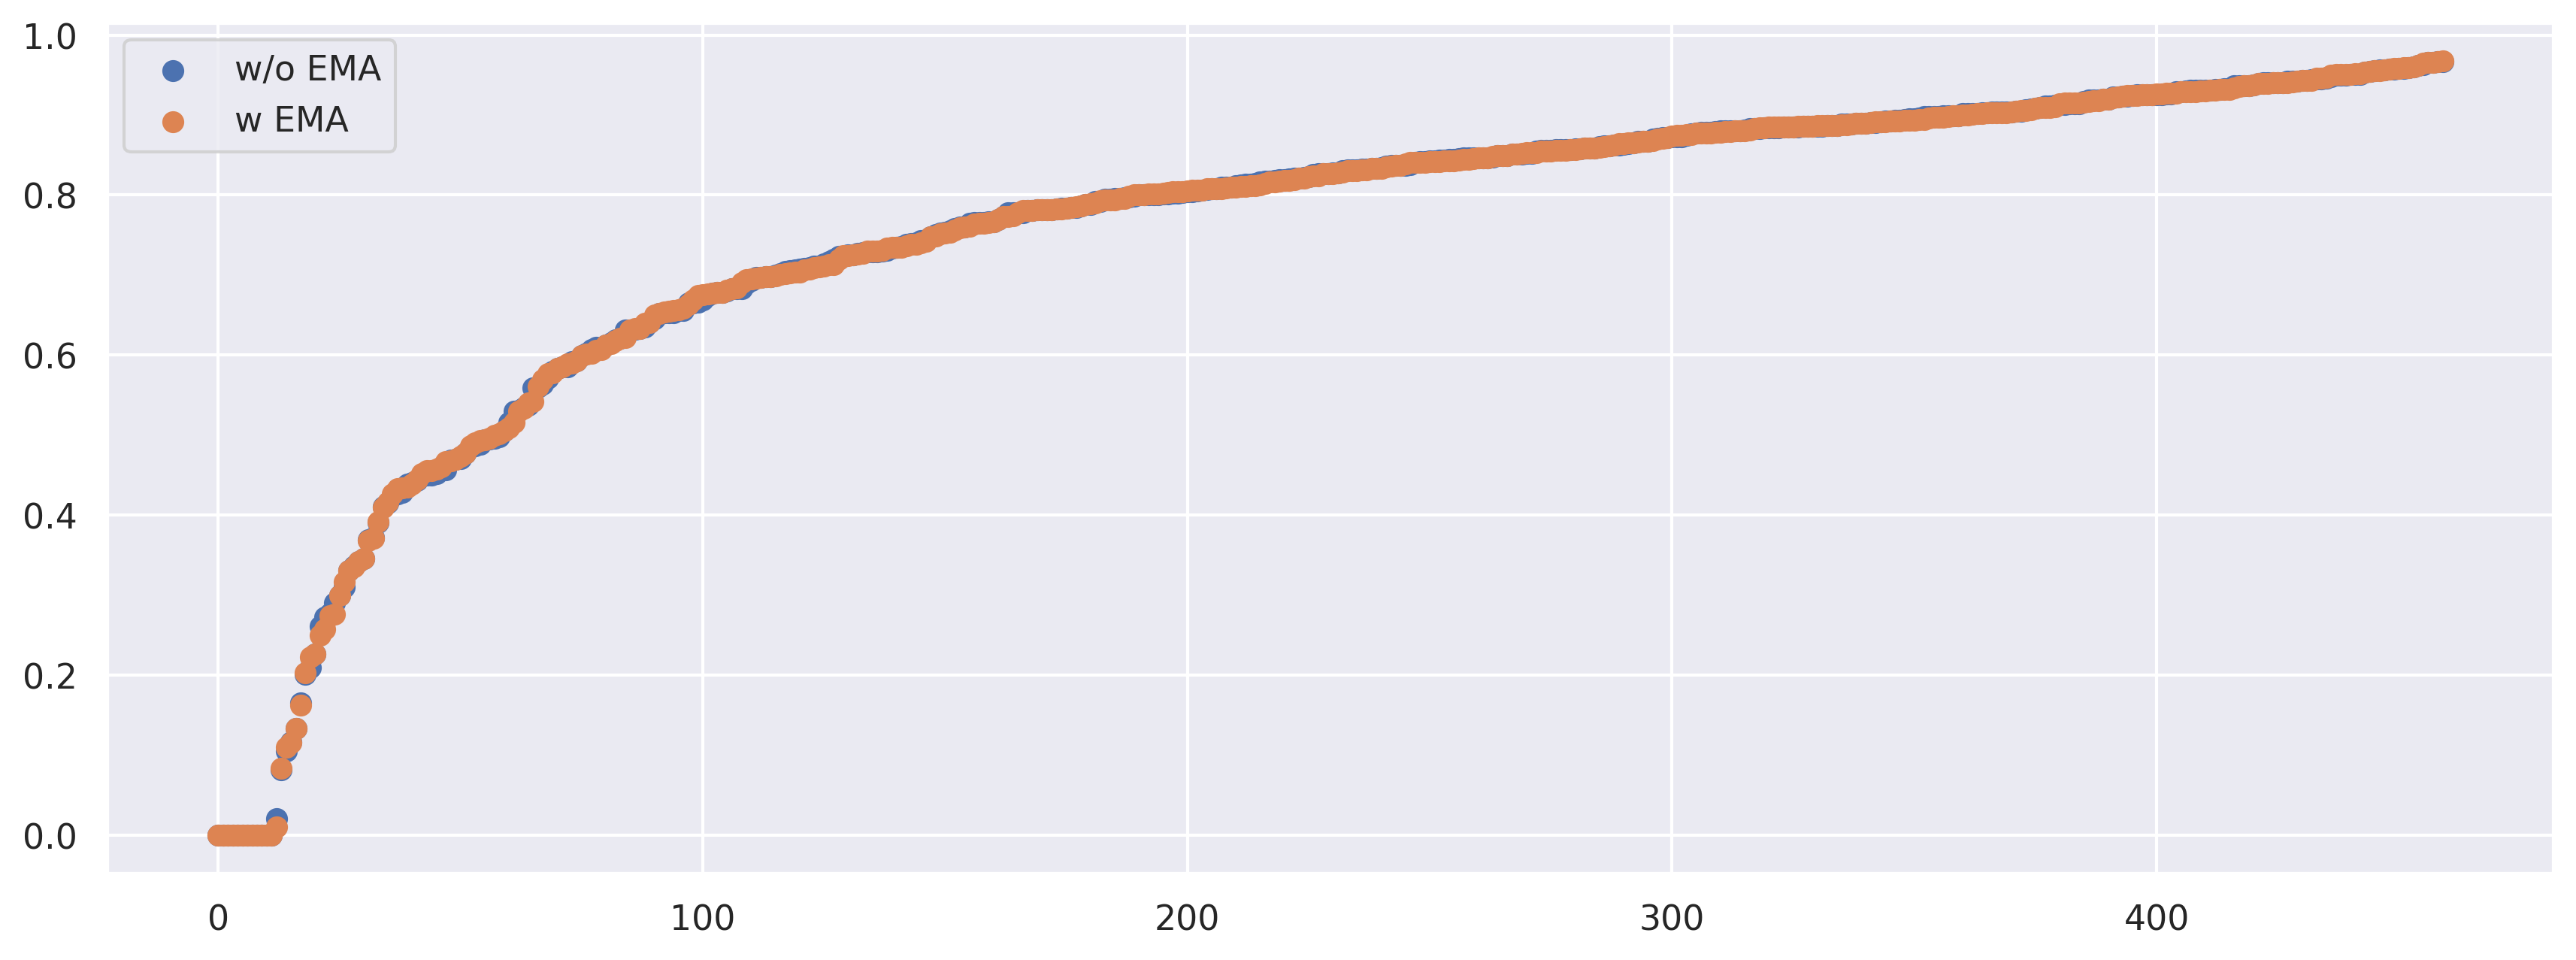

In [13]:
plt.subplots(figsize=(14, 5), dpi=300)
plt.scatter(np.arange(len(ious)), ious[idxs].numpy(), label='w/o EMA')
plt.scatter(np.arange(len(ious_ema)), ious_ema[idxs_ema].numpy(), label='w EMA')
plt.legend()

In [14]:
ious_ema.mean().item(), ious.mean().item()

(0.7537883440457961, 0.7540285338703848)

## Analyses of the worst cases

We have errors when 
* only tumor boundaries are slightly visible but the texture seems to be the same as healthy
* the tumor is not consistent - it has 2 or 3 focuses, but on the training masks there is alway 1 continious spot, hence, the model fails to merge them
* there are several suspisious regions and the model makes a wrong choice
* the model detect the tumor correctly but it is to unconfident to step over the threshold
* the initial tumor is very small

In [299]:
i = -1
# i = 0
# i = 70

In [300]:
def plot_by_index(i, idxs, dataset, threshold=0.5):
    j = idxs[i].item()
    image, mask, label = dataset.get_raw(j)
    pred_p = pred_probs[j]
    pred_mask = (pred_p > threshold).astype('uint8')
    pred_logits = pred_masks[j]
    print(i, j, ious[j].item())
    print(label, labels[j])

    pred = (image * pred_mask[..., None]).astype(np.uint8)
    plot_images([image, mask, pred_mask, pred_p, pred_logits, pred], nrows=2, figsize=(24, 15),
                 names=['Image', 'True Mask', "Predicted Mask",
                        'Predicted Probabilities', 'Pred Logits', 'Layout'])

0 413 0.0
1 [5.81361839e-08 9.99709189e-01 2.90770637e-04]


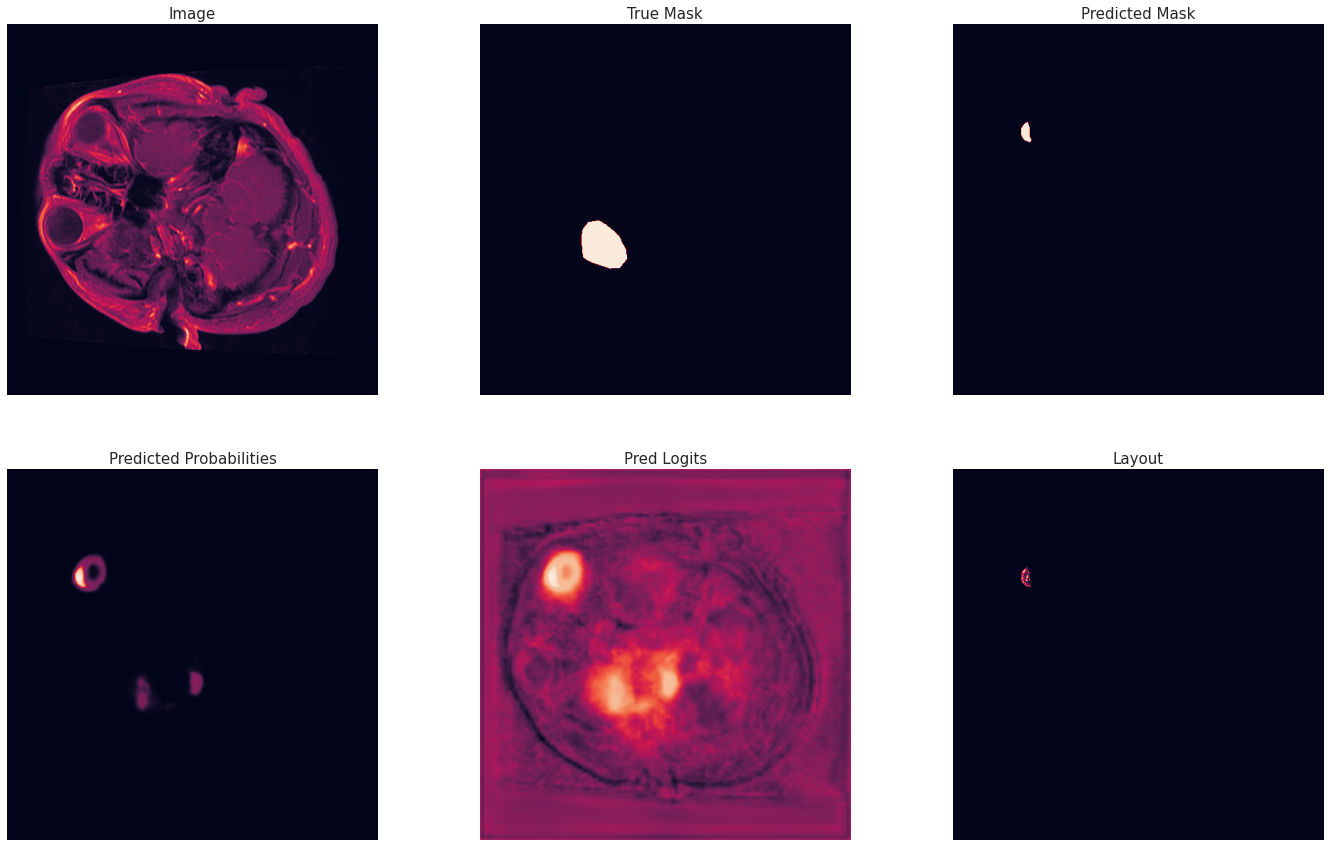

In [302]:
plot_by_index(0, idxs, dataset)

1 217 0.0
2 [1.03998623e-07 1.70109303e-07 9.99999762e-01]


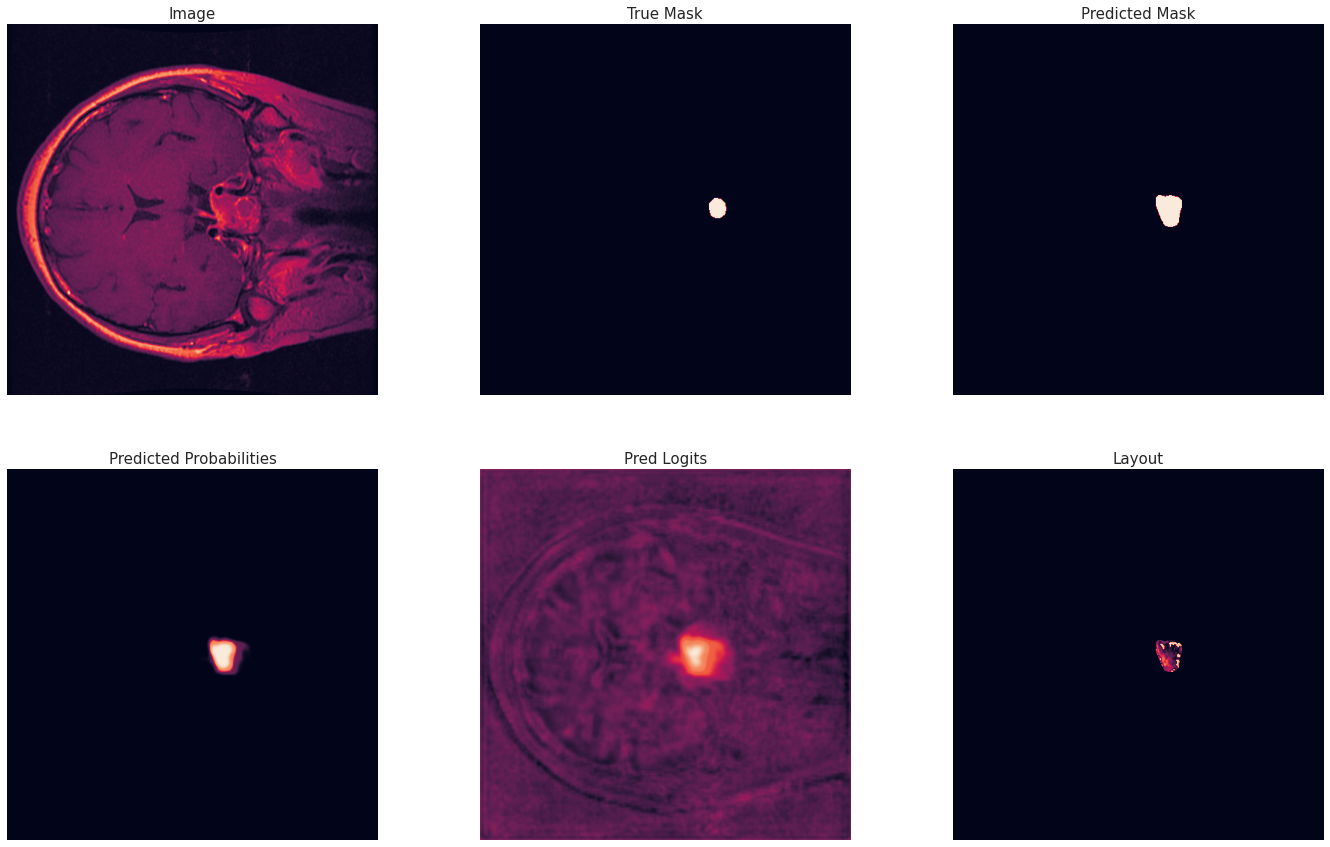

In [304]:
plot_by_index(1, idxs, dataset)

2 25 0.0
1 [1.42628541e-12 1.00000000e+00 1.11947829e-09]


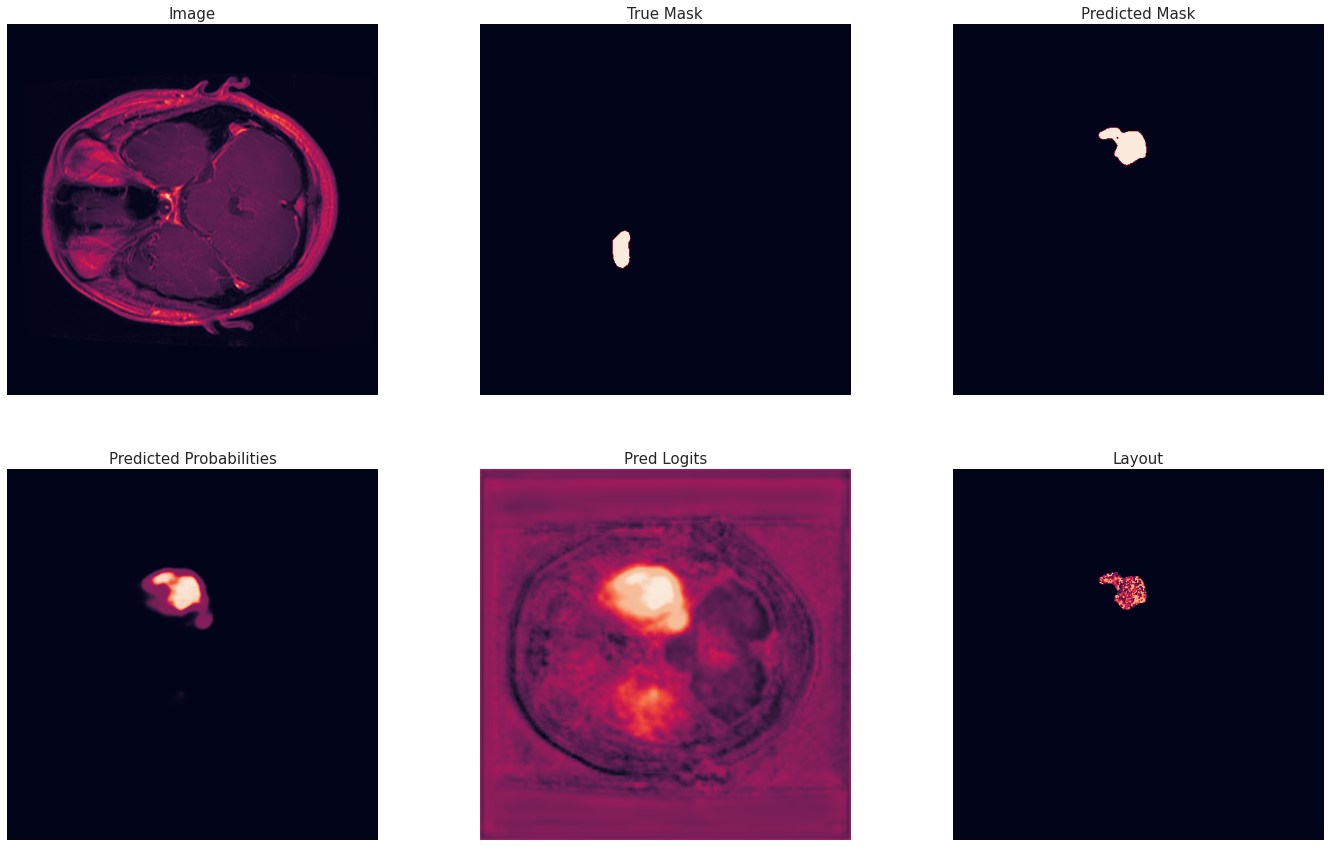

In [310]:
plot_by_index(2, idxs, dataset)

3 115 0.0
1 [7.51993329e-11 1.00000000e+00 2.44964333e-08]


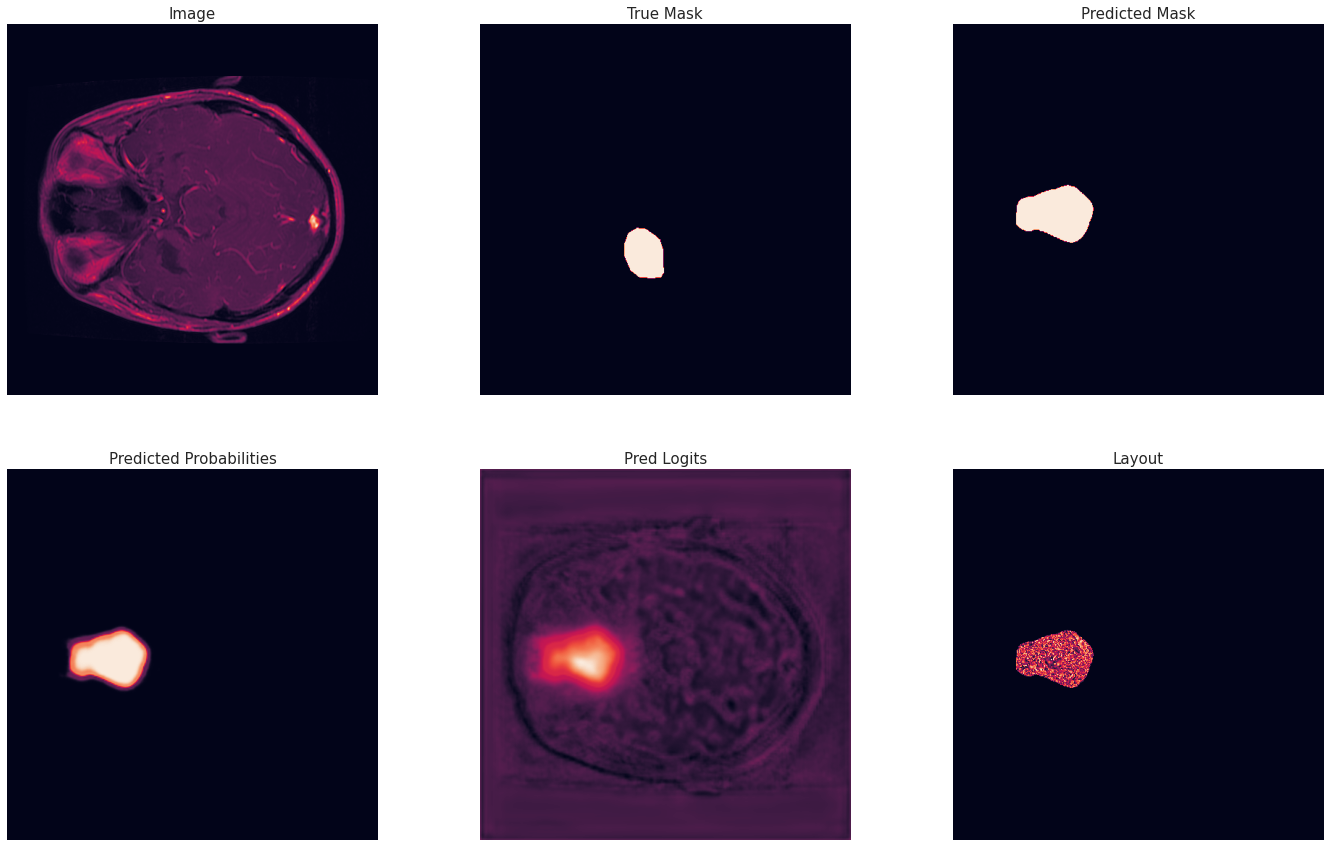

In [311]:
plot_by_index(3, idxs, dataset)

4 268 0.0
1 [5.53460966e-12 1.00000000e+00 8.65676475e-10]


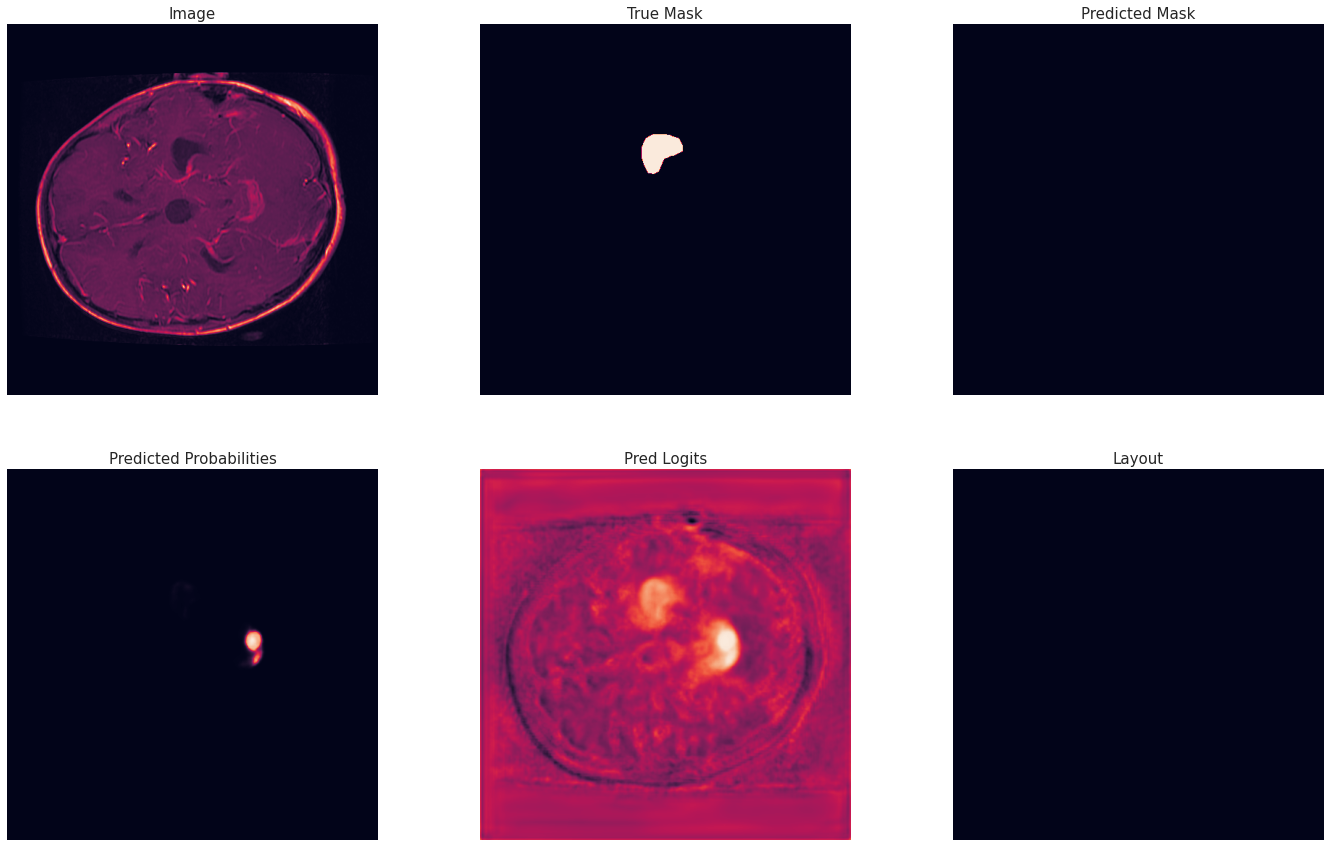

In [312]:
plot_by_index(4, idxs, dataset)

5 151 0.0
1 [2.19023960e-07 9.99695659e-01 3.04169225e-04]


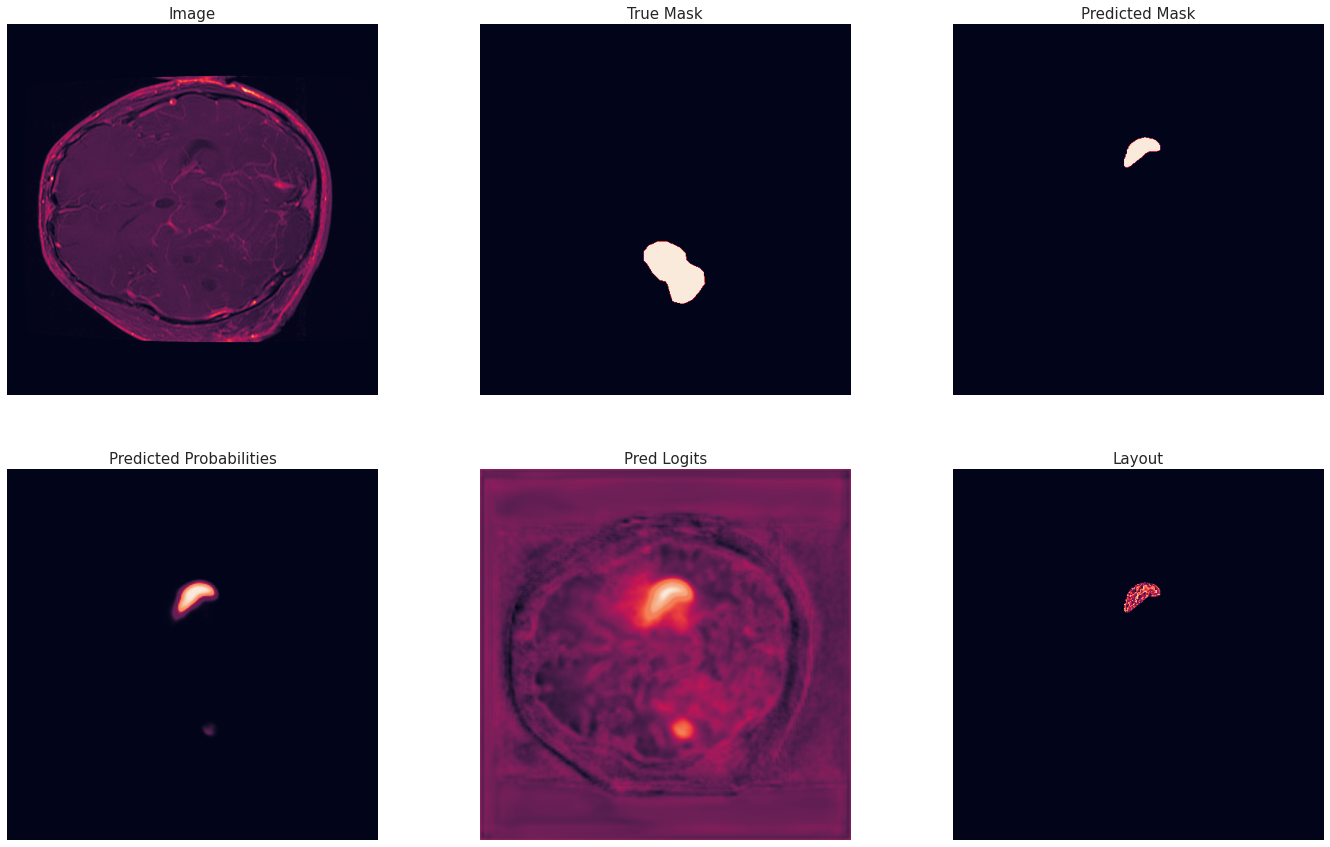

In [313]:
plot_by_index(5, idxs, dataset)

6 337 0.0
1 [5.11752814e-02 9.48824525e-01 1.47084023e-07]


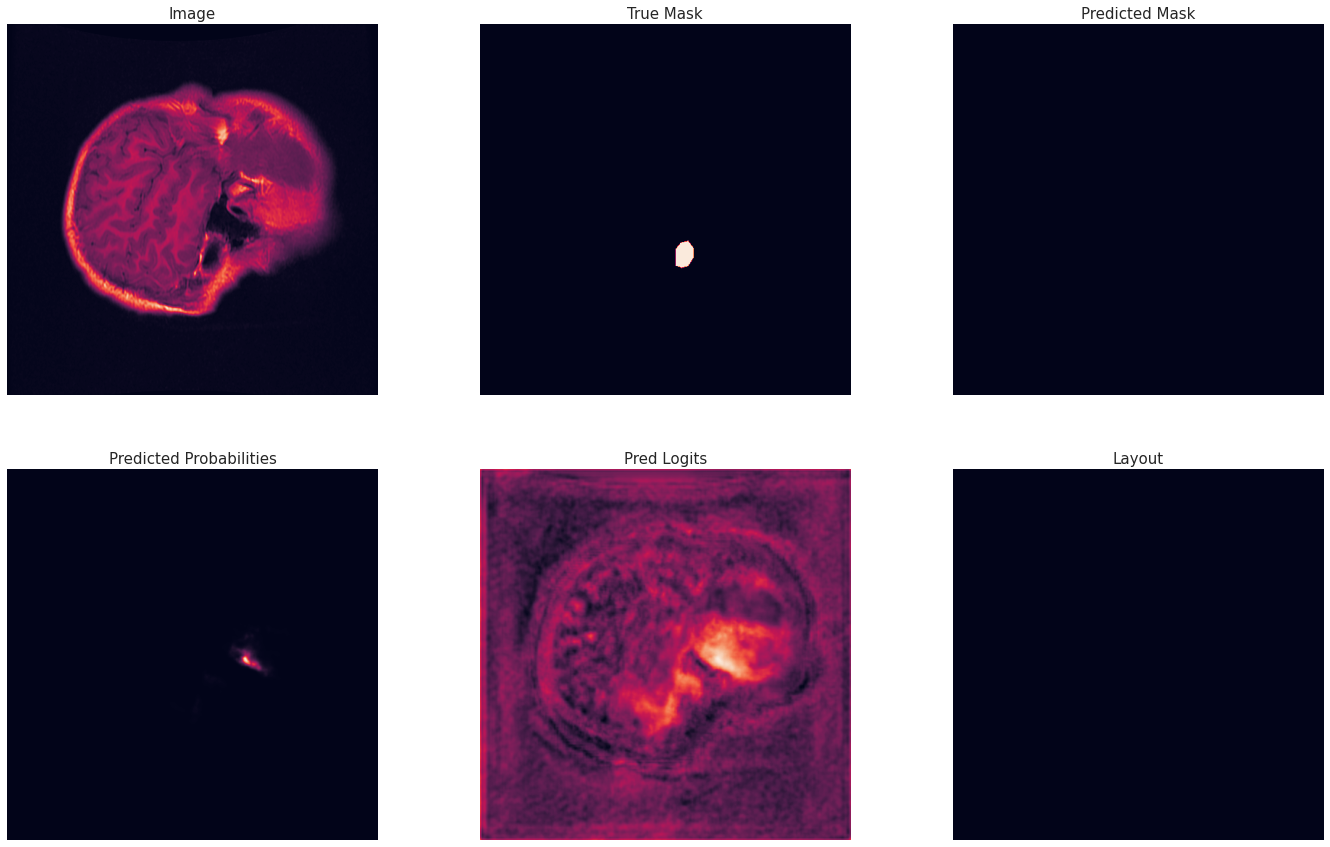

In [314]:
plot_by_index(6, idxs, dataset)

7 213 0.0
1 [3.20183468e-13 1.00000000e+00 1.77067250e-08]


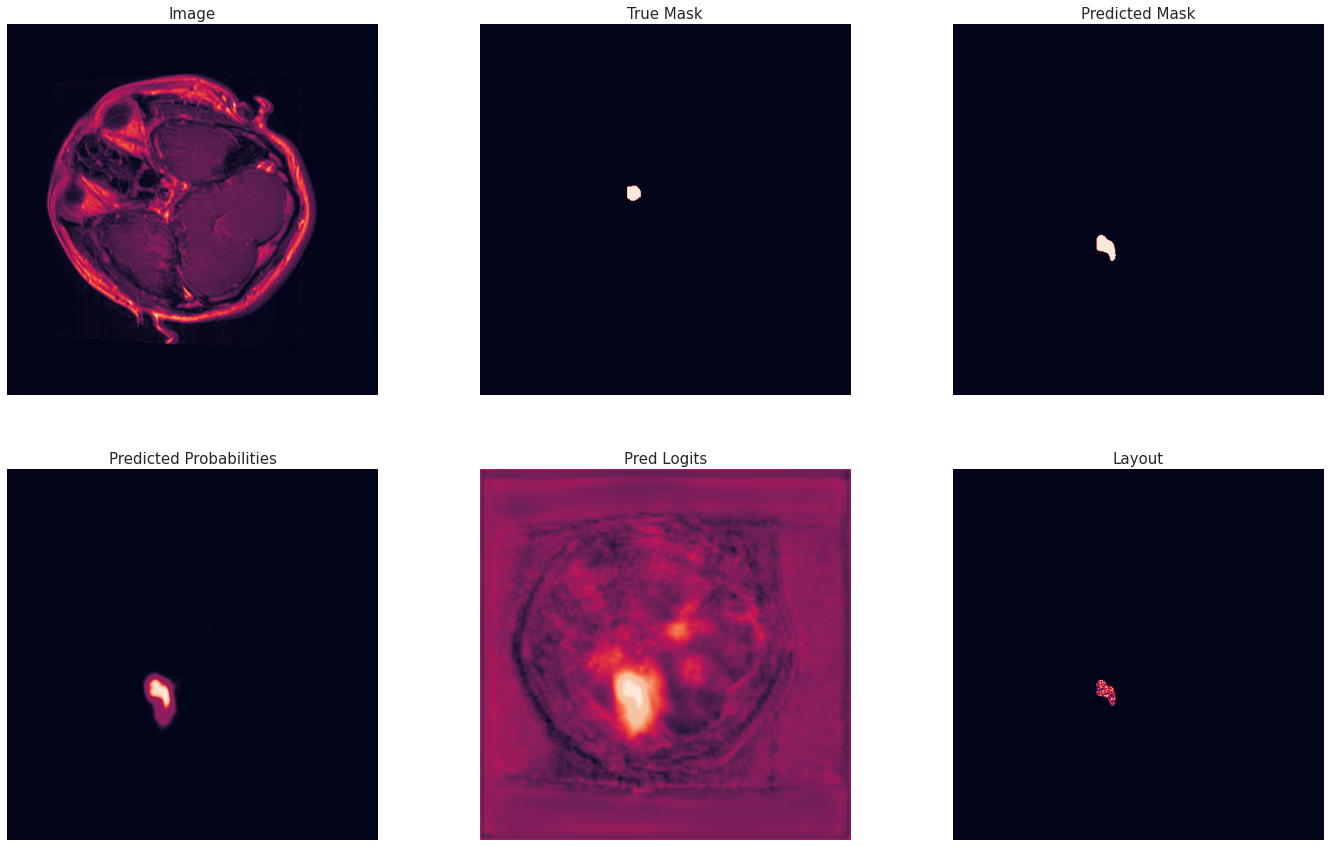

In [315]:
plot_by_index(7, idxs, dataset)

8 263 0.0
1 [2.66130087e-07 9.99999762e-01 1.57193247e-09]


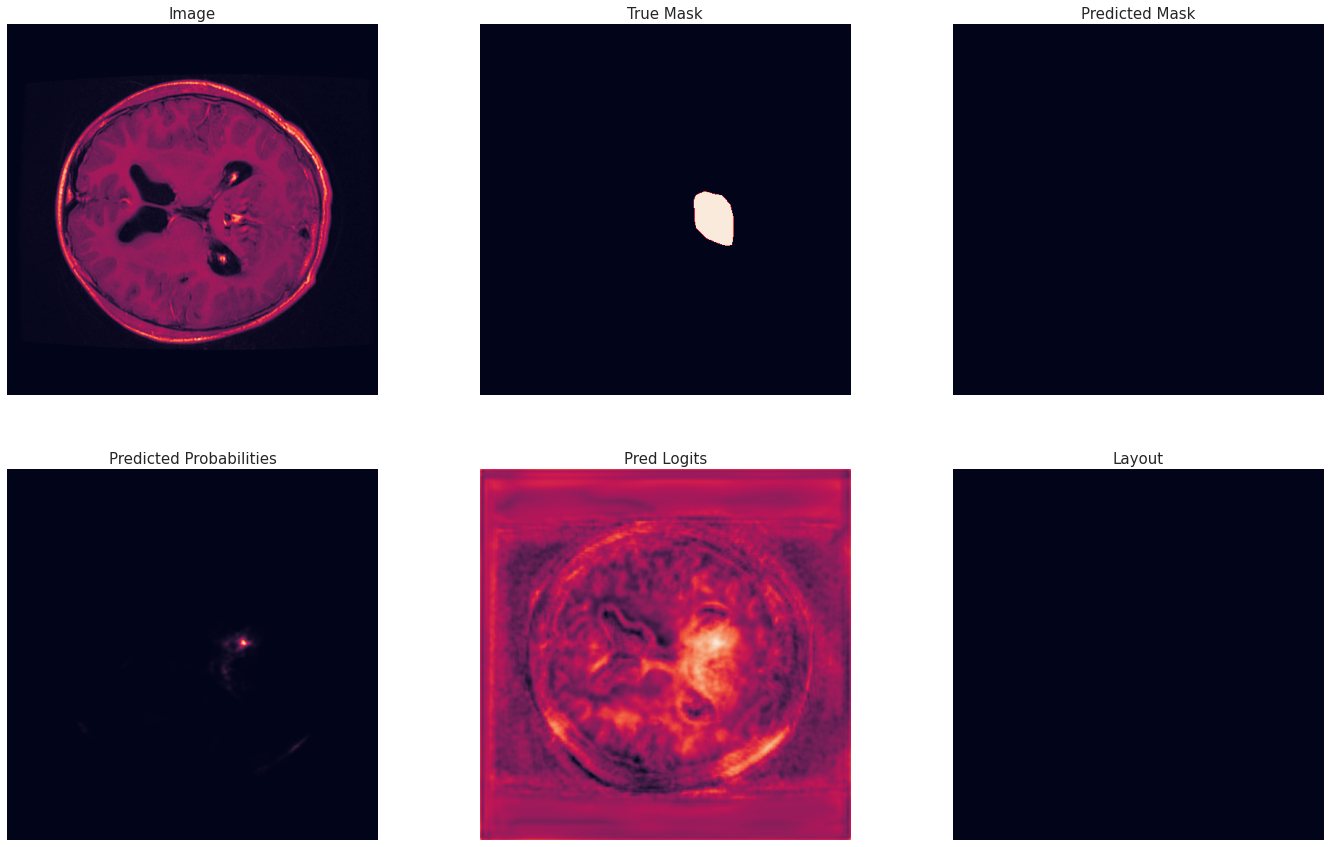

In [316]:
plot_by_index(8, idxs, dataset)

9 304 0.0
1 [9.99491903e-08 9.99997020e-01 2.84960083e-06]


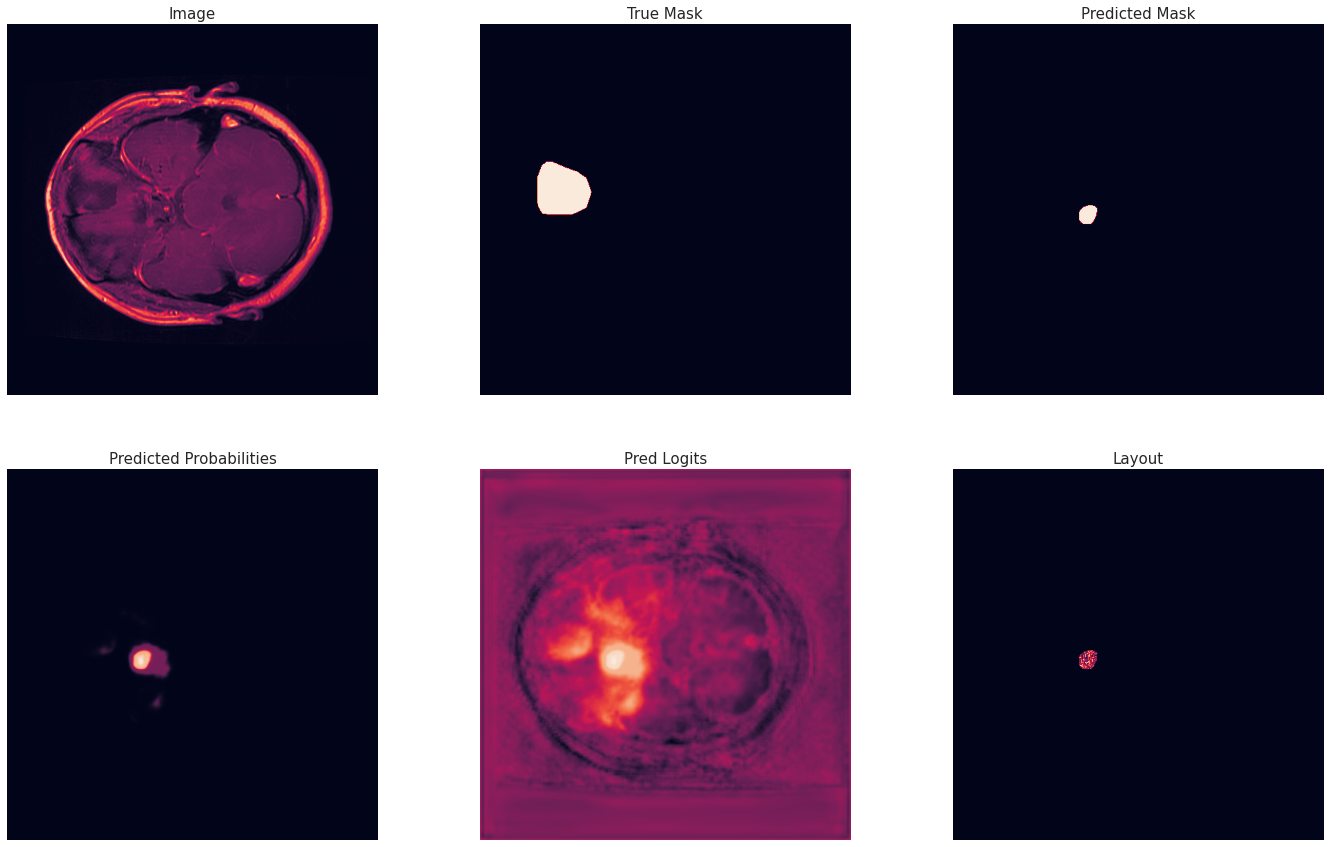

In [317]:
plot_by_index(9, idxs, dataset)

10 417 0.0
1 [1.46672159e-08 1.00000000e+00 6.33466240e-12]


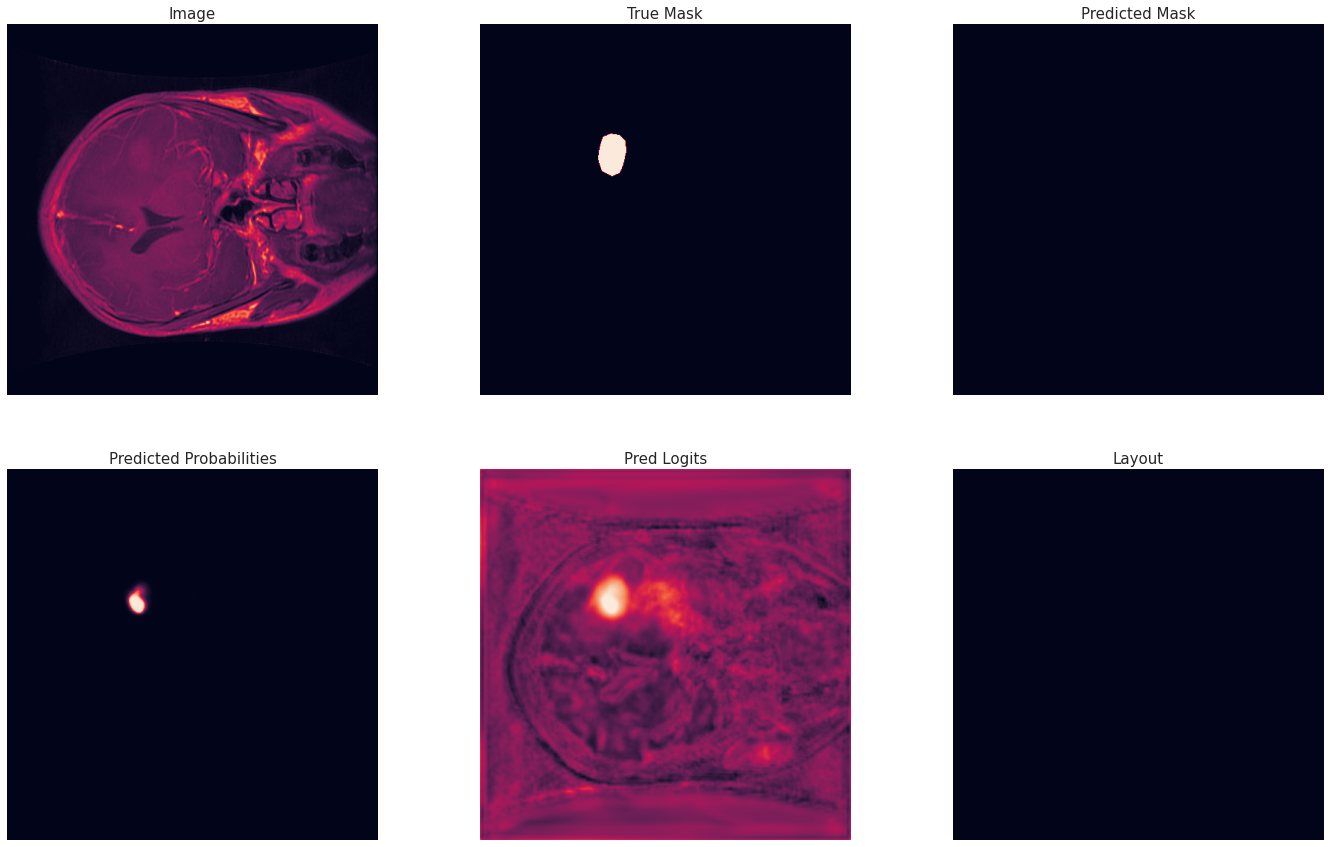

In [305]:
plot_by_index(10, idxs, dataset)

11 387 0.0
1 [6.97352665e-09 9.99994636e-01 5.32115337e-06]


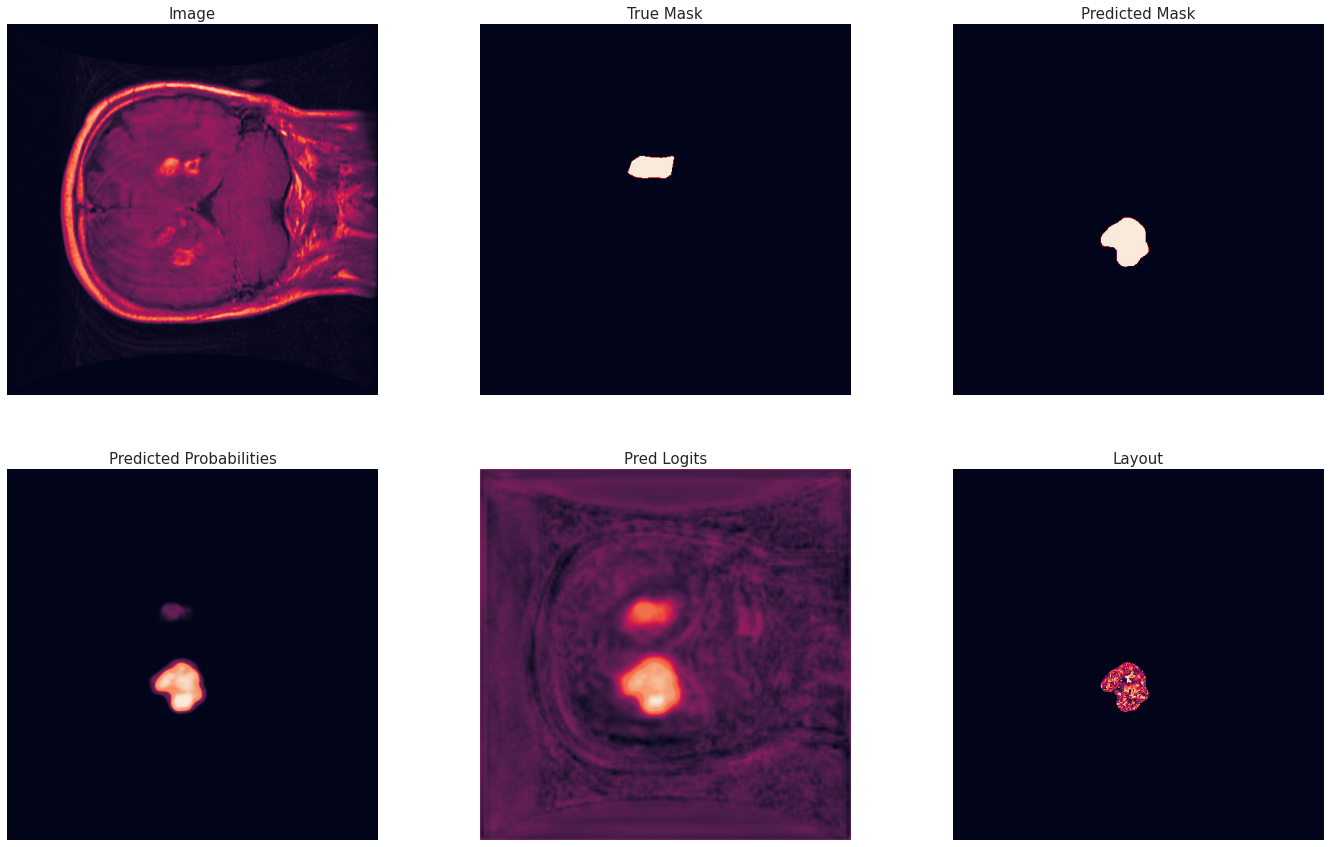

In [306]:
plot_by_index(11, idxs, dataset)

12 299 0.0
1 [2.14225757e-08 9.99998689e-01 1.26135035e-06]


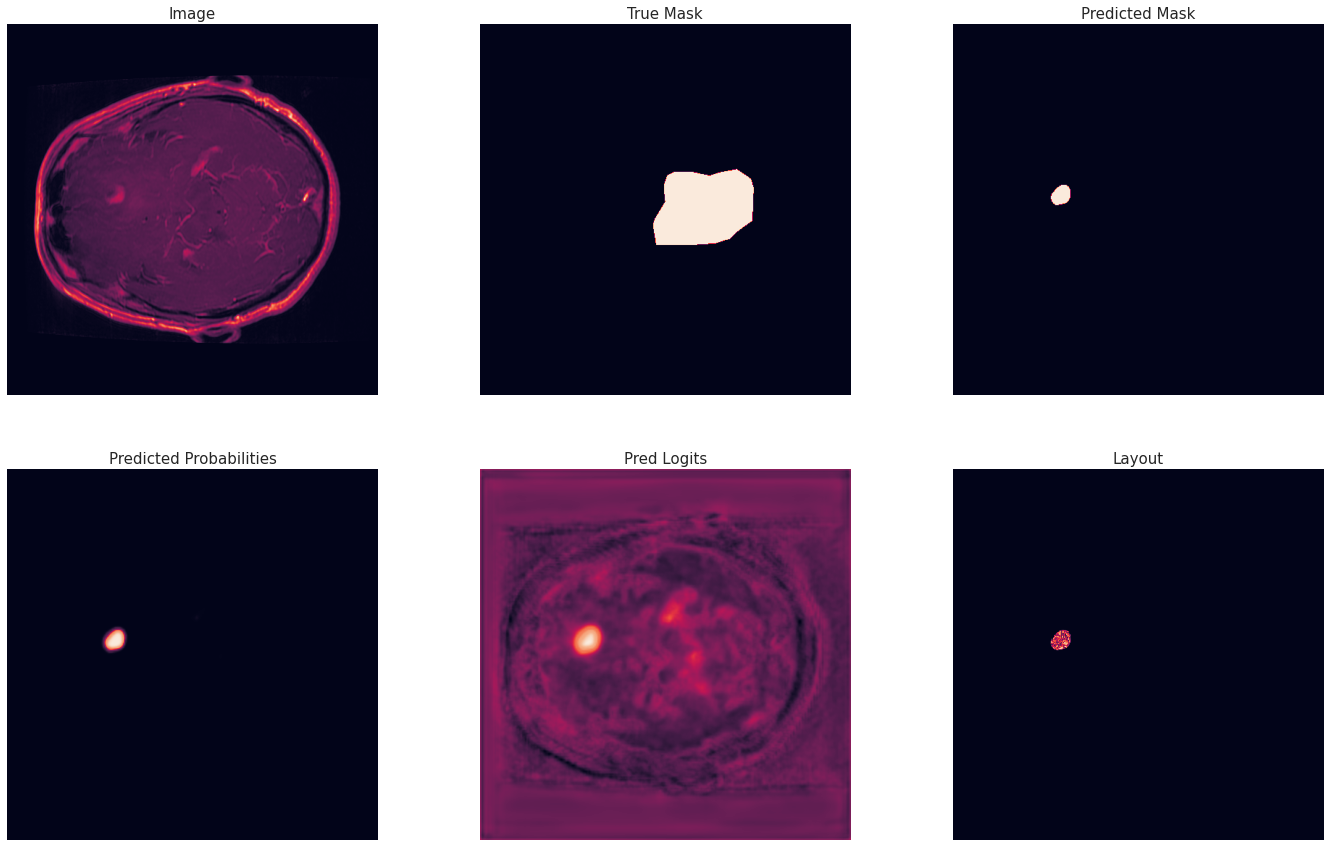

In [307]:
plot_by_index(12, idxs, dataset)

13 385 0.0
1 [1.00745551e-10 1.00000000e+00 1.67361702e-09]


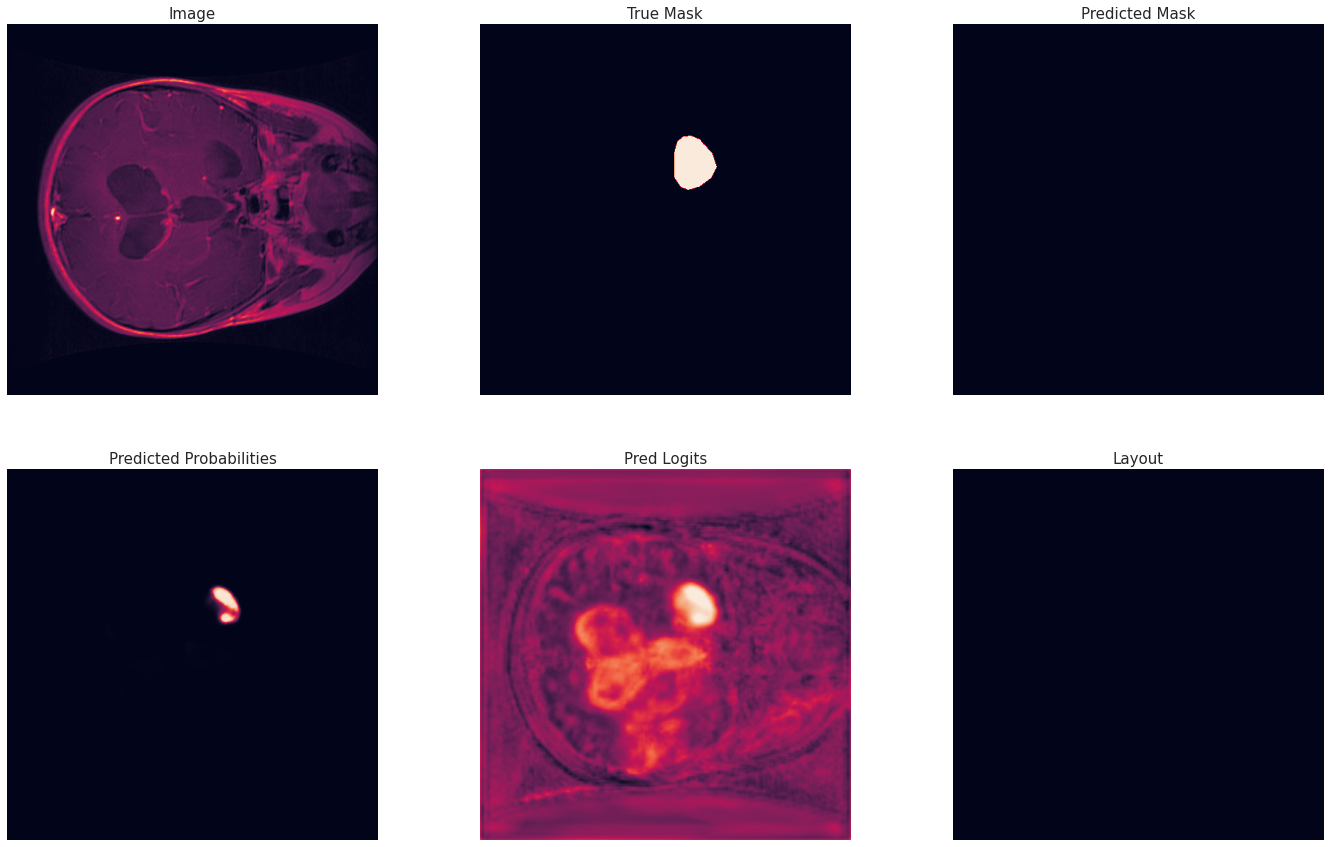

In [308]:
plot_by_index(13, idxs, dataset)

14 280 0.0027440219521756176
1 [1.88643309e-10 9.99999762e-01 2.61247123e-07]


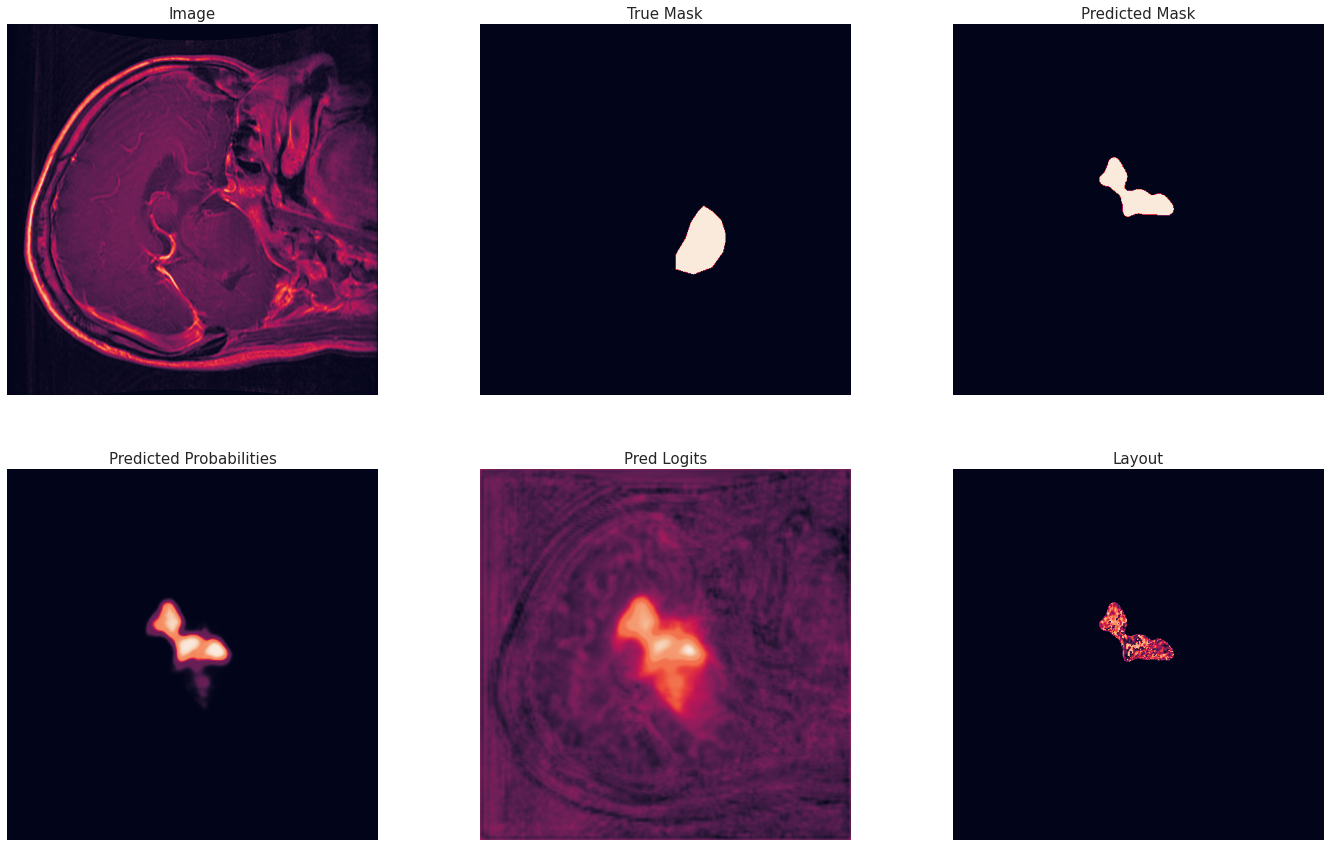

In [309]:
plot_by_index(14, idxs, dataset)

## Analyses of the best results

We have good results when
* the tumor is rather contrast, big and its texture/color is more or less uniform, but it may contain some not uniform contaminations. It may not have sharp edges
* the tumor may have the color very close to some other healthy region in the same picture, but it should be assimetric in this case

459 126 0.9700138094298678
0 [9.99997497e-01 2.65232813e-07 2.23337224e-06]


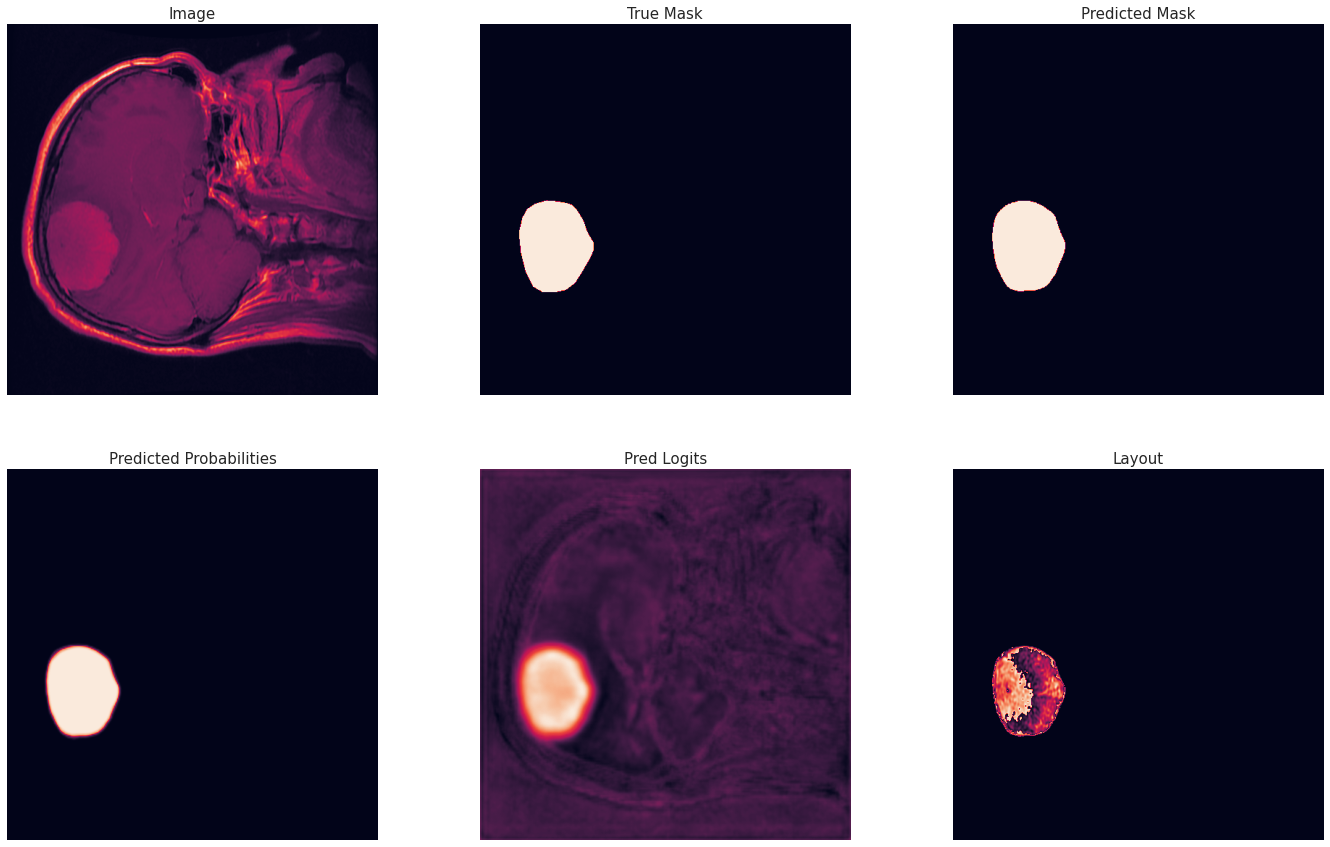

In [318]:
plot_by_index(len(idxs)-1, idxs, dataset)

443 370 0.9521995464852607
1 [7.32890669e-07 9.99999046e-01 2.48000731e-07]


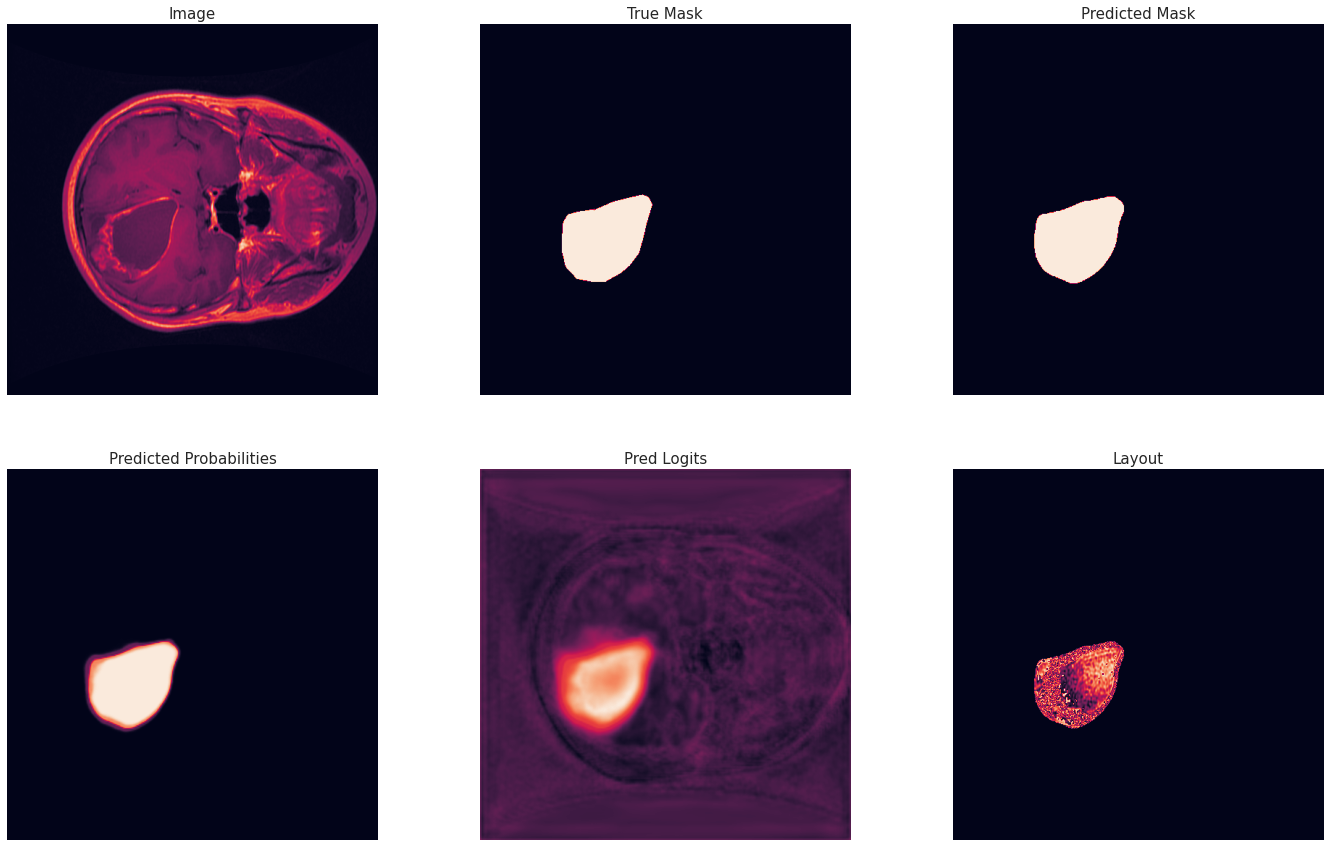

In [325]:
plot_by_index(len(idxs)-17, idxs, dataset)

413 186 0.9330186558777254
2 [7.50461652e-07 1.46192251e-05 9.99984622e-01]


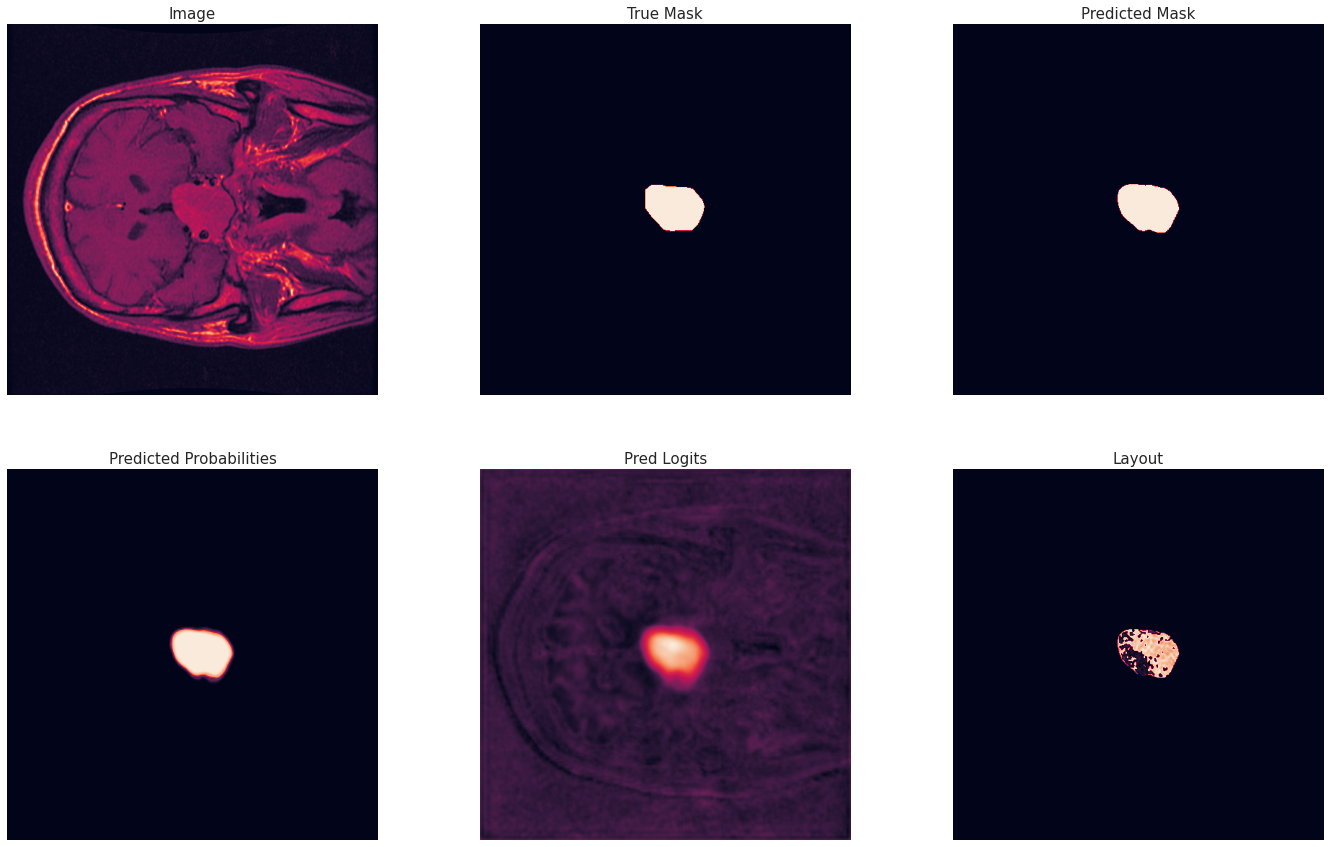

In [329]:
plot_by_index(len(idxs)-47, idxs, dataset)

390 432 0.9218349849682663
1 [2.64470989e-04 9.99735534e-01 3.79363874e-10]


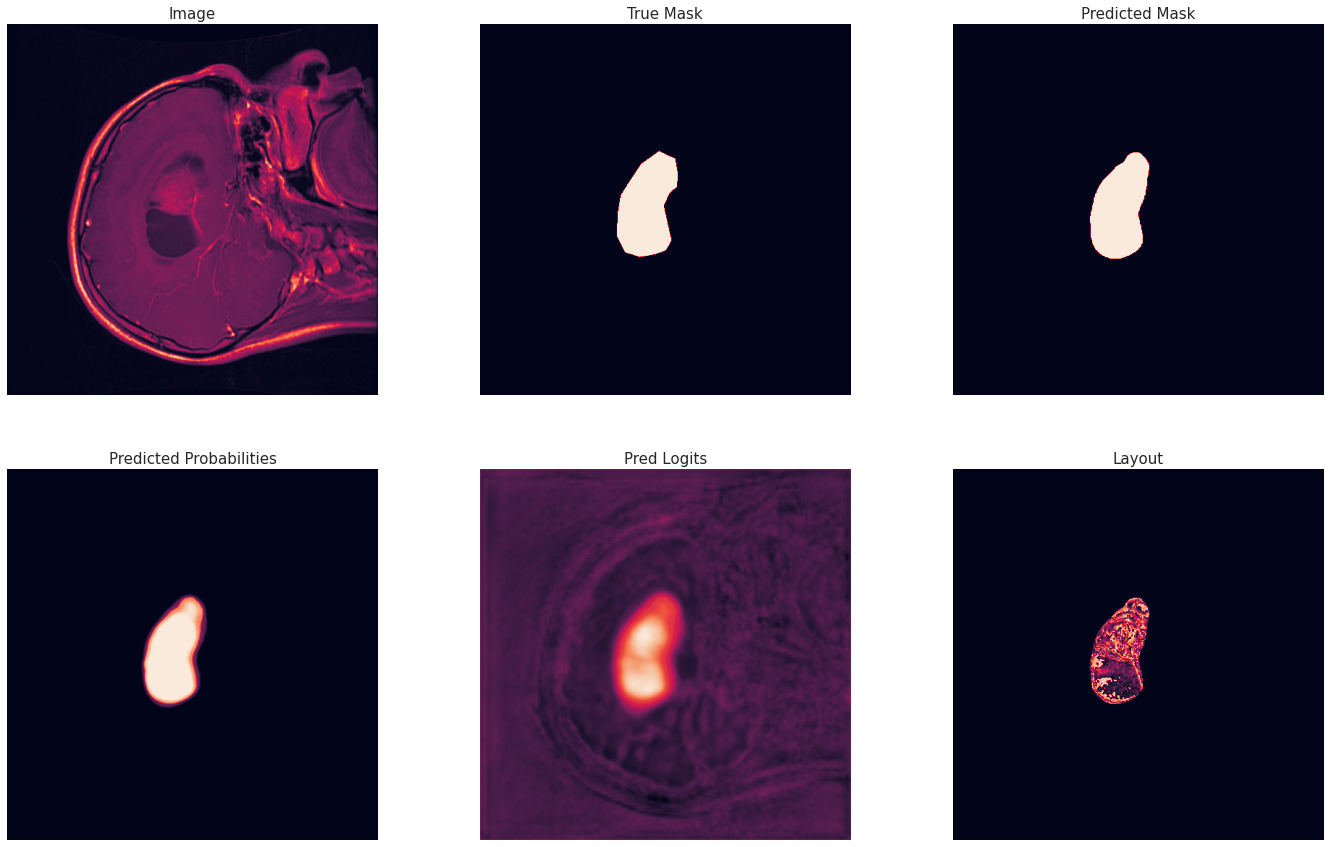

In [332]:
plot_by_index(len(idxs)-70, idxs, dataset)

380 363 0.9163018022604623
1 [9.47732187e-05 9.99889493e-01 1.57678132e-05]


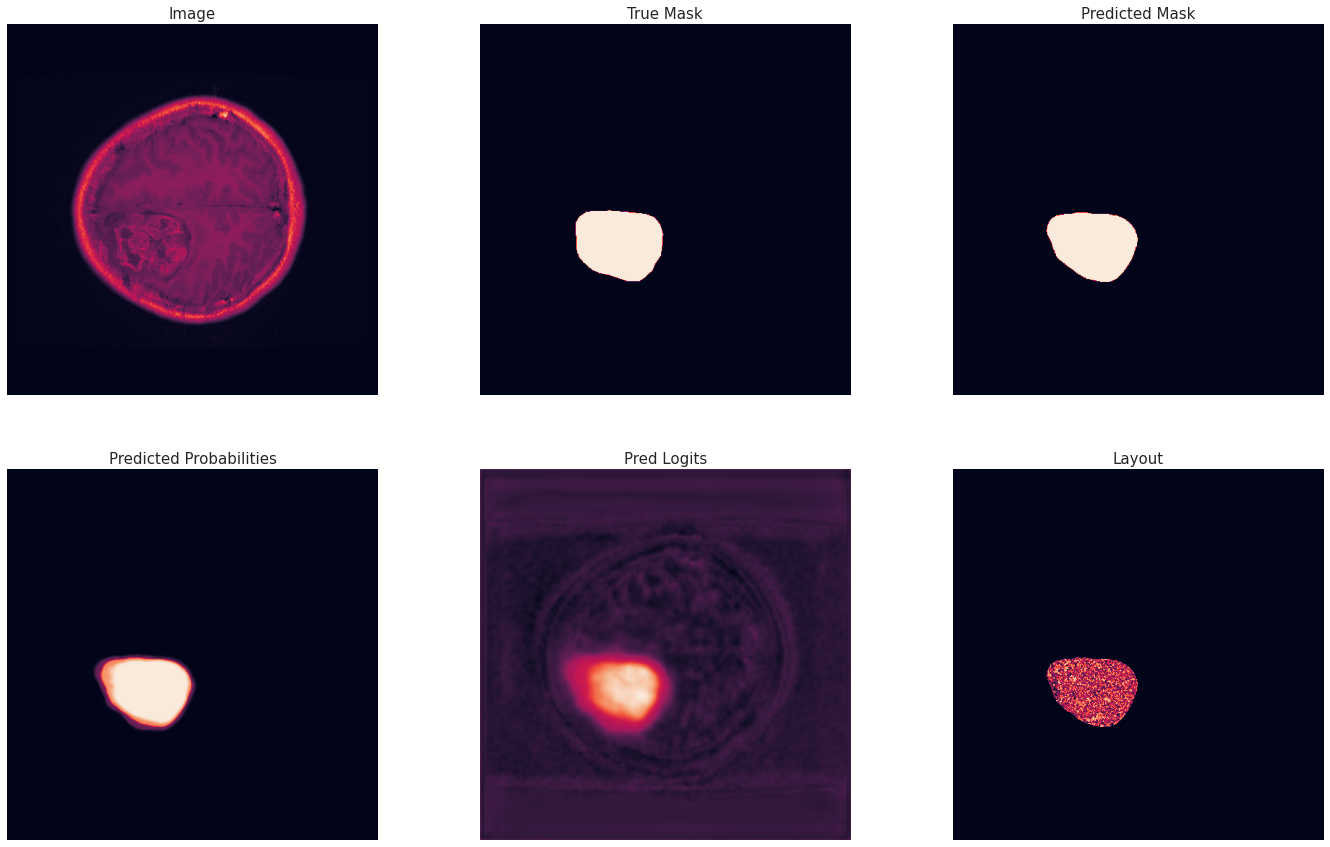

In [333]:
plot_by_index(len(idxs)-80, idxs, dataset)

365 147 0.9090270460133474
1 [1.04905257e-06 9.98854160e-01 1.14477787e-03]


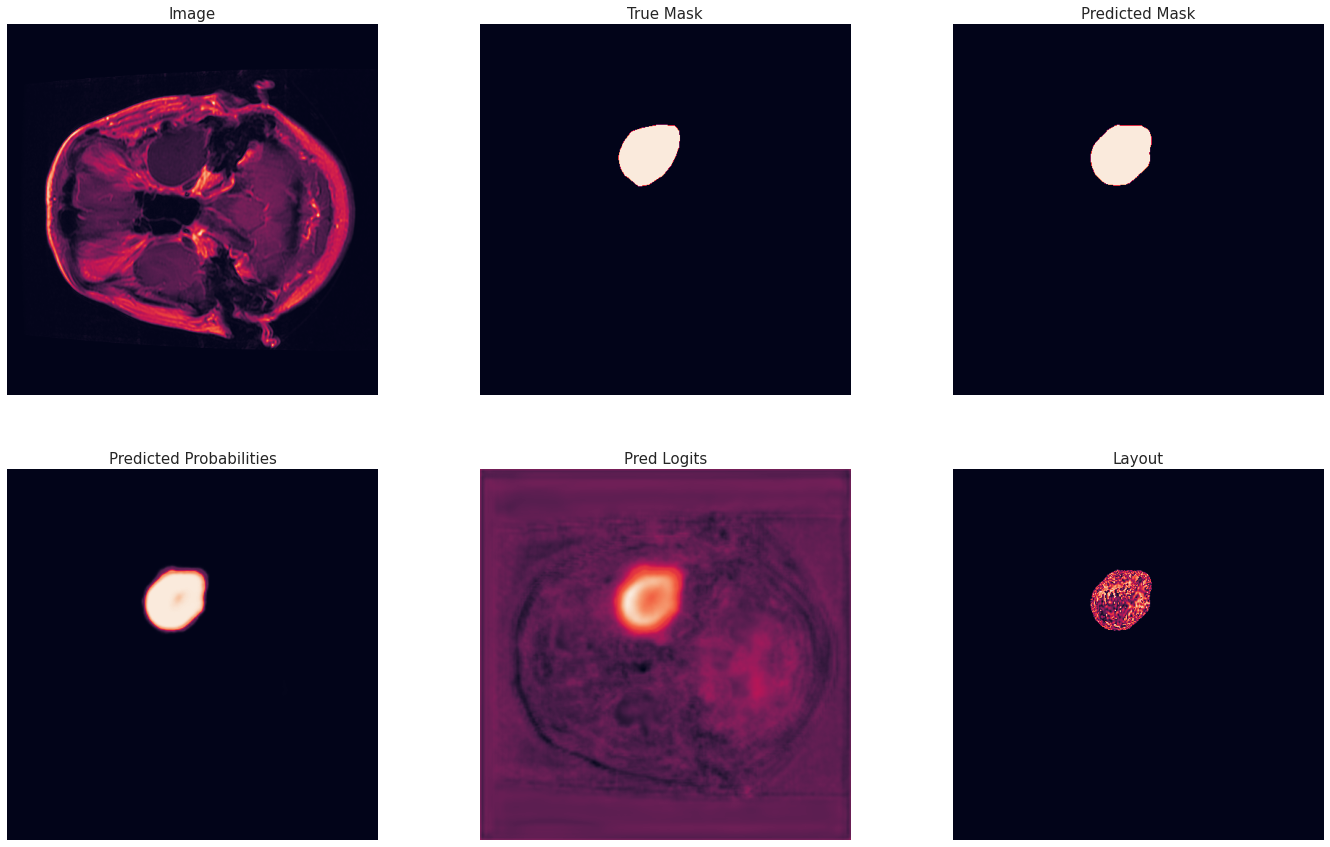

In [336]:
plot_by_index(len(idxs)-95, idxs, dataset)

355 71 0.9036778939217963
1 [2.86765703e-06 9.99995351e-01 1.74881905e-06]


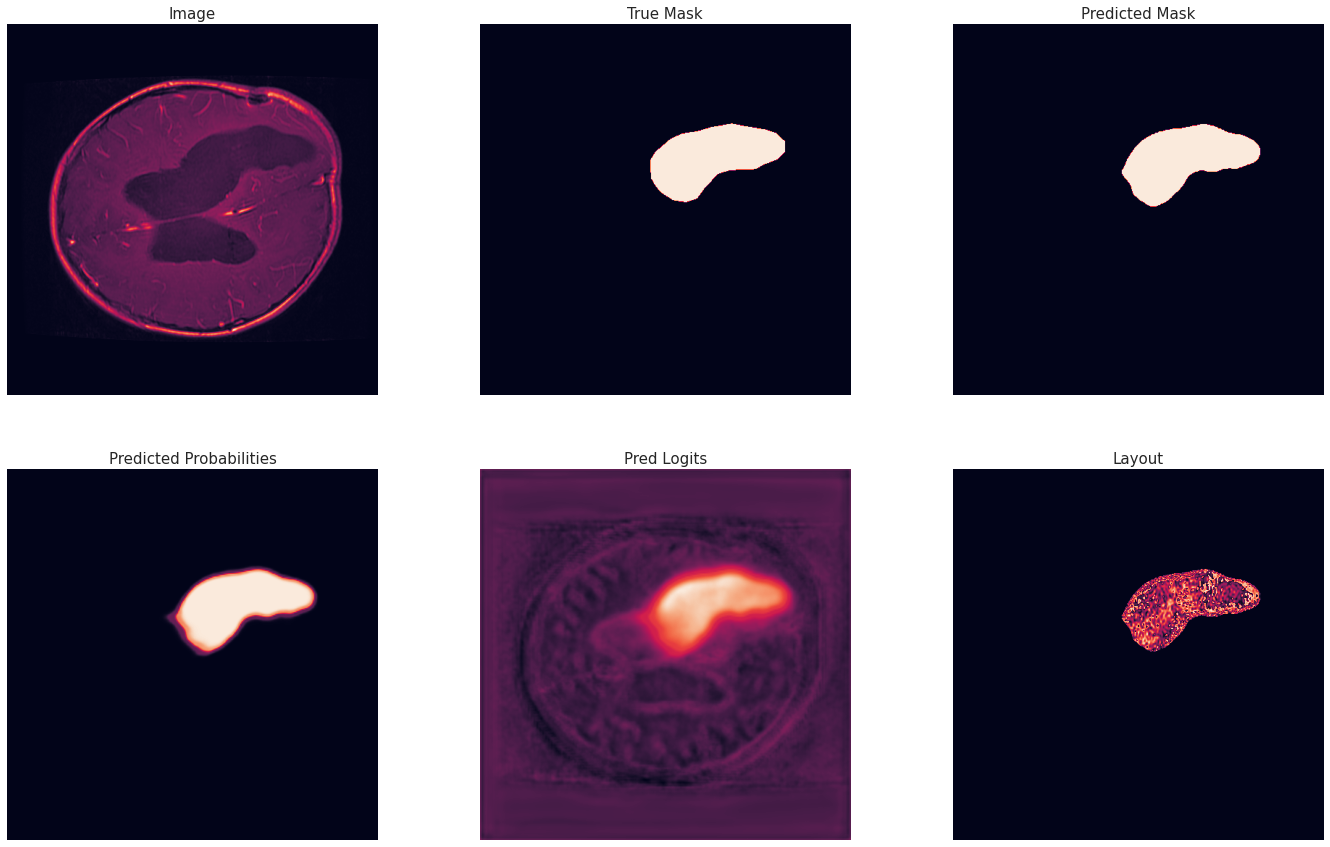

In [337]:
plot_by_index(len(idxs)-105, idxs, dataset)